In [1]:
from PIL import Image
import os
import random
import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms,models
to_tensor = transforms.ToTensor()
to_img = transforms.ToPILImage()

USE_CUDA = torch.cuda.is_available()

In [2]:
from unet import UNet

In [3]:
def resize_img(img,max_width = 400):
    w,h = img.size
    max_height = int(h / w * max_width)
    img = img.resize((max_width,max_height),Image.ANTIALIAS)
    return img

def get_random_pos(big_box,small_box):
    bw,bh = big_box
    sw,sh = small_box
    x = random.randrange(0,bw-sw)
    y = random.randrange(0,bh-sh)
    return(x,y)

class myDataset(Dataset):
    def __init__(self, n = 10,path_org = '../data/src', path_wm = '../data/watermarks',path_out = "data/out",gen=False):
        super().__init__()
        self.n = n
        self.path_org = path_org
        self.path_wm = path_wm
        self.path_out = path_out
        self.gen = gen
        self.imglist= [x for x in os.listdir(self.path_org) if x.endswith('.jpg')]
        self.imglist_size = len(self.imglist)
        self.wmlist = [x for x in os.listdir(self.path_wm) if x.endswith('.png')]
        self.wmlist_size = len(self.wmlist)
        
    def __len__(self):
        return self.n
       
    def __getitem__(self,idx):
        ix = random.randrange(0,self.imglist_size)
        iwm = random.randrange(0,self.wmlist_size)

        img = Image.open(os.path.join(self.path_org,self.imglist[ix])).convert("RGB")
        img = resize_img(img)
        imgwm = Image.open(os.path.join(self.path_wm,self.wmlist[iwm]))
        imgwm = imgwm if imgwm.size[0] <150 else resize_img(imgwm,random.randrange(100,150))
        imgwm = imgwm.convert("RGBA")
        r,g,b,a = imgwm.split()

        x,y = get_random_pos(img.size,(200,200))
        img = img.crop((x,y,x+200,y+200))

        target = Image.new("RGBA",(200,200),(0,0,0,0))
        target.paste(img,(0,0))

        x,y = get_random_pos((200,200),imgwm.size)
        target.paste(imgwm,(x,y),a)
        target = target.convert("RGB")

        if self.gen:
            target.save(os.path.join(self.path_out,str(idx) + ".png"))
            out =  {"src":img, "wm":target}
        else:
            src_t = to_tensor(img)
            wm_t = to_tensor(target)
            out = {"src_t":src_t, "wm_t":wm_t}
        return out

In [4]:
train_ds  = myDataset(n = 1000)
train_dl =DataLoader(train_ds,batch_size=5)

In [13]:

model = UNet(3,3)
if USE_CUDA :model.cuda()
optim = torch.optim.RMSprop(model.parameters(),lr=1e-4)

In [12]:
L1_Loss= torch.nn.L1Loss()
MSE_Loss = torch.nn.MSELoss()
def loss_func(x,y):
    d = torch.abs(x - y)
    d = d /(0.3+y)
    return torch.mean(d)
def loss_func_vgg(x,y):
    return MSE_Loss(vgg_layer(x),vgg_layer(y))

In [38]:
for i,x in enumerate(train_dl):
    src_t = x['src_t']
    wm_t = x['wm_t']
    if  USE_CUDA:
        src_t = src_t.cuda()
        wm_t = wm_t.cuda()
    out = model(wm_t)
    loss = loss_func_vgg(out,src_t)
   
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % 10 ==9:
         print(f"{i},loss={loss.data}")

9,loss=0.004641782026737928
19,loss=0.006756014656275511
29,loss=0.0041008200496435165
39,loss=0.006561153568327427
49,loss=0.008763830177485943
59,loss=0.008520564995706081
69,loss=0.006558476015925407
79,loss=0.012709301896393299
89,loss=0.005530779715627432
99,loss=0.0033191845286637545
109,loss=0.004240762908011675
119,loss=0.007309869397431612
129,loss=0.008902491070330143
139,loss=0.007887918502092361
149,loss=0.005058634094893932
159,loss=0.006182091310620308
169,loss=0.006516536697745323
179,loss=0.008319840766489506
189,loss=0.006055419333279133
199,loss=0.005234744865447283


# end

In [37]:
optim.param_groups[0]['lr'] =2e-6

In [ ]:
xx = myDataset(n=10,gen=True)

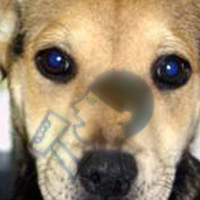

In [41]:
to_img(model(train_ds[0]['wm_t'].unsqueeze(0).cuda()).squeeze(0).cpu())

In [ ]:
to_img(train_ds[0]['wm_t'])

In [6]:
vgg = models.vgg16(pretrained=True)
vgg.eval()
for p in vgg.parameters():
    p.required_grad=False
#if USE_CUDA:vgg.cuda()
    
def vgg_layer(x,n=4):
    for i in range(n):
        x = vgg.features[i].cuda()(x)
    return x

In [ ]:
to_img(vgg_layer(train_ds[0]['wm_t'].unsqueeze(0).cuda()).cpu()[0,6])